# Imports


In [133]:
from google.colab import drive
drive.mount('/content/drive')

from IPython.display import clear_output
import time
import requests
from bs4 import BeautifulSoup
from urllib.parse import quote
import pickle
import re
from collections import Counter
import pandas as pd
from datetime import date
today = date.today()
import yfinance as yf


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Key Functions

In [45]:

def get_jobs_for_keyword(keyword, pages=10,pause=2):
    """
    Scrape job postings for a specific keyword.

    Args:
        keyword (str): The job title or keyword to search for.
        pages (int): The number of pages to scrape.

    Returns:
        list: A list of dictionaries containing job details.
    """
    jobs = []
    base_url = "https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search"

    for page in range(pages):
        print('.  ', page)
        # Removed location from the URL
        url = f"{base_url}?keywords={quote(keyword)}&start={25 * page}"
        response = requests.get(url, timeout=5)

        if response.status_code != 200:
            print(f"Failed to fetch page {page + 1}: {response.status_code}")
            continue

        soup = BeautifulSoup(response.content, "html.parser")
        job_cards = soup.find_all('div', class_='base-search-card__info')

        for card in job_cards:
            title = card.find('h3').text.strip() if card.find('h3') else None
            company = card.find('a', class_='hidden-nested-link').text.strip() if card.find('a', class_='hidden-nested-link') else None
            # Removed the location extraction
            if card.parent:
              job_id = card.parent.get('data-entity-urn').split(':')[-1]
              job_url = f"https://www.linkedin.com/jobs/view/{job_id}/"
            else:
              job_id = None
              job_url = None

            jobs.append({
                'title': title,
                'company': company,
                'job_id':job_id,
                'job_url': job_url,
            })

        time.sleep(pause)


    return jobs

def convert_to_days(date_posted):
    """
    Convert a human-readable time string (e.g., '1 week ago', '2 months ago')
    into a float representing the number of days.
    """
    time_mapping = {
        "minute": 1 / 1440,  # 1 minute = 1/1440 days
        "hour": 1 / 24,      # 1 hour = 1/24 days
        "day": 1,            # 1 day = 1 day
        "week": 7,           # 1 week = 7 days
        "month": 30.4,       # 1 month = 30.4 days (average)
        "year": 365          # 1 year = 365 days
    }

    # Split the string into components
    if date_posted:
      parts = date_posted.split()

      if len(parts) < 2:
          return None  # Handle unexpected formats

      try:
          # Extract the number and time unit
          number = float(parts[0])
          unit = parts[1].rstrip('s')  # Remove plural (e.g., 'weeks' -> 'week')

          # Convert to days
          return number * time_mapping.get(unit, 1)
      except (ValueError, KeyError):
          return None  # Handle invalid cases gracefully
def split_location(location, mapping):
    """
    Splits a location string into city and state.

    Parameters:
        location (str): The location string (e.g., "Chicago, IL" or "Greater San Francisco Area").
        mapping (dict): A dictionary mapping special cases to (city, state) tuples.

    Returns:
        tuple: A tuple (city, state) with the split values.
    """
    if location in mapping:
        return mapping[location]

    # Split by comma for standard cases like "City, State"
    if "," in location:
        parts = location.split(",")
        city = parts[0].strip()
        state = parts[1].strip()

        # Handle cases like "New York, United States"
        if state.lower() == "united states":
            state = abbreviation_mapping.get(city, "Unknown")  # The first part is actually the state in this subcase
            city="Unknown"
        return city, state

    # Handle edge cases where location doesn't fit the standard pattern
    return "Unknown", "Unknown"

# Mappings to standardize location data for job postings
mapping = {
    'San Francisco Bay Area': ("San Francisco", "CA"),
    'Greater Chicago Area':("Chicago","IL"),
    'New York City Metropolitan Area': ("New York City", "NY"),
    'Greater Wilmington Area': ("Wilmington", "DE"),
    'Greater Sioux Falls Area': ("Sioux Falls", "SD"),
    'Raleigh-Durham-Chapel Hill Area': ("Raleigh", "NC"),
    'Buffalo-Niagara Falls Area': ("Buffalo", "NY"),
    'Greater Hartford': ("Hartford", "CT"),
    'Greater Boston': ("Boston", "MA"),
    'Greater Houston': ("Houston", "TX"),
    'Greater Reno Area': ("Reno", "NV"),
    'Greater Scranton Area': ("Scranton", "PA"),
    'Louisville Metropolitan Area': ("Louisville", "KY"),
    'Kansas City Metropolitan Area': ("Kansas City", "MO"),
    'Cincinnati Metropolitan Area': ("Cincinnati", "OH"),
    'Omaha Metropolitan Area': ("Omaha", "NE"),
    'Washington DC-Baltimore Area': ("Washington, DC", "DC"),
    'Atlanta Metropolitan Area': ("Atlanta", "GA"),
    'Greater Minneapolis-St. Paul Area': ("Minneapolis", "MN"),
    'Los Angeles Metropolitan Area': ("Los Angeles", "CA"),
    'Miami-Fort Lauderdale Area': ("Miami", "FL"),
    'Utica-Rome Area': ("Utica", "NY"),
    'Greater Cleveland': ("Cleveland", "OH"),
    'Las Vegas Metropolitan Area': ("Las Vegas", "NV"),
    'Albany, New York Metropolitan Area':("Albany","NY"),
    'Columbus, Ohio Metropolitan Area':("Columbus","OH"),
}

# Additional Mappings to standardize location data for job postings

abbreviation_mapping = {
    "Wisconsin": "WI",
    "Virginia": "VA",
    "New Jersey": "NJ",
    "Illinois": "IL",
    "Hawaii": "HI",
    "California": "CA",
    "Washington": "WA",
    "Texas": "TX",
    "Florida": "FL",
    "Arizona": "AZ",
    "Colorado": "CO",
    "Missouri": "MO",
    "New York": "NY",

}

# Job Categories and Associated Keywords
job_categories = {
    'engineering_it': [
        'engineer',
        'engineering',
        'software',
        'developer',
        'information technology',
        'technical',
        'it consultant',
        'data analytics',
        'data science',
        'data engineering',
    ],
    'legal': [
        'legal',
        'counsel',
        'compliance',
        'legal advisor',
        'fair lending',
        'paralegal',
        'lawyer',
        'employment law',
        'data protection',
        'regulatory compliance',
        'regulatory law'
    ],
    'operations_cs': [
        'fraud investigator',
        'fraud strategist',
        'processor',
        'business control',
        'product support specialist',
        'client service',
        'quality',
        'agent',
        'support',
        'strategy'
    ],
    'sales': [
        'account executive',
        'sales',
        'sales development representative',
        'account management',
        'lead generation'
    ],
    'marketing': [
        'marketing',
        'brand management',
        'loyalty',
        'rewards',
        'search engine',
        'campaign performance',
        'direct mail',
        'email marketing'
        'social media',
        'seo'
    ],
    'hr_admin': [
        'compensation',
        'talent acquisition',
        'human',
        'benefits',
        'payroll specialist',
        'diversity',
        'inclusion',
        'administrative'
    ],
    'product_rnd': [
        'product development',
        'product manager',
        'research',
        'development'
    ],
    'gen_ai': [
        'generative ai',
        'gen ai',
        'large language model',
        'llms',
        'openai',
        'artificial intelligence',
        'chatgpt',
    ],
    'finance': [
        'underwrit',
        'accounting',
        'accountant',
        'financial reporting',
        'treasury',
        'financial advisor',
        'trader',
        'financial services',
        'financial analyst',
        'valuation',
        'investment banking'
    ]
}


# Ticker information for company search
public_companies_mapping = {
 "Enova" : {"full name": 'Enova International'  ,              "ticker": 'ENVA',  'exchange': 'NYSE'},
 "Discover" : {"full name": 'Discover Financial Services'  ,      "ticker": 'DFS',  'exchange': 'NYSE'},
 "OppFi" : {"full name": 'OppFi Inc.' ,                        "ticker": 'OPFI',  'exchange': 'NYSE'},
 "HPR" : {"full name": 'HighPoint Resources Corp.' ,         "ticker": 'HPR',  'exchange': 'NYSE'},
 "Affirm" : {"full name": 'Affirm Holdings Inc.' ,              "ticker": 'AFRM',  'exchange': 'NASDAQ'},
 "OP Bancorp" : {"full name": 'OP Bancorp'  ,                       "ticker": 'OPBK',  'exchange': 'NASDAQ'},
 "Coinbase" : {"full name": 'Coinbase Global Inc.' ,              "ticker": 'COIN',  'exchange': 'NASDAQ'},
 "Remitly" : {"full name": 'Remitly Global Inc.' ,               "ticker": 'RELY',  'exchange': 'NASDAQ'},
 "Houlihan Lokey" : {"full name": 'Houlihan Lokey Inc.' ,               "ticker": 'HLI',  'exchange': 'NYSE'},
 "NASDAQ" : {"full name": 'NASDAQ Inc.' ,                       "ticker": 'NDAQ',  'exchange': 'NASDAQ'},
 "First BanCorp" : {"full name": 'First BanCorp'  ,                    "ticker": 'FBP',  'exchange': 'NYSE'},
 "Hamilton Lane" : {"full name": 'Hamilton Lane Inc.' ,                "ticker": 'HLNE',  'exchange': 'NASDAQ'},
 "Cullen/Frost Bankers" : {"full name": 'Cullen/Frost Bankers Inc.' ,         "ticker": 'CFR',  'exchange': 'NYSE'},
 "Triumph Financial" : {"full name": 'Triumph Financial Inc.' ,            "ticker": 'TFIN',  'exchange': 'NASDAQ'},
 "Esquire Financial Holdings" : {"full name": 'Esquire Financial Holdings Inc.' ,   "ticker": 'ESQ',  'exchange': 'NASDAQ'},
 "TransUnion" : {"full name": 'TransUnion'  ,                       "ticker": 'TRU',  'exchange': 'NYSE'},
 "Upstart" : {"full name": 'Upstart Holdings Inc.' ,             "ticker": 'UPST',  'exchange': 'NASDAQ'},
 "BlackLine" : {"full name": 'BlackLine Inc.' ,                    "ticker": 'BL',  'exchange': 'NASDAQ'},
 "MarketAxess" : {"full name": 'MarketAxess Holdings Inc.' ,         "ticker": 'MKTX',  'exchange': 'NASDAQ'},
 "Block" : {"full name": 'Block Inc. (formerly Square Inc.)',  "ticker": 'SQ',  'exchange': 'NYSE'},
 "SoFi" : {"full name": 'SoFi Technologies Inc.' ,            "ticker": 'SOFI',  'exchange': 'NASDAQ'},
 "Robinhood" : {"full name": 'Robinhood Markets Inc.' ,            "ticker": 'HOOD',  'exchange': 'NASDAQ'},
 "SVB Financial Group" : {"full name": 'SVB Financial Group'  ,              "ticker": 'SIVB',  'exchange': 'NASDAQ'},
 "American Express" : {"full name": 'American Express Co.' ,              "ticker": 'AXP',  'exchange': 'NYSE'},
 "MoneyLion" : {"full name": 'MoneyLion Inc.' ,                    "ticker": 'ML',  'exchange': 'NYSE'},
 "Visa" : {"full name": 'Visa Inc.' ,                         "ticker": 'V',  'exchange': 'NYSE'},
 "Flywire" : {"full name": 'Flywire Corp.' ,                     "ticker": 'FLYW',  'exchange': 'NASDAQ'},
 "Deutsche Boerse'" : {"full name": 'Deutsche Börse AG'  ,                "ticker": 'DB1',  'exchange': 'XETRA'},
 "Mr. Cooper Group" : {"full name": 'Mr. Cooper Group Inc.' ,             "ticker": 'COOP',  'exchange': 'NASDAQ'},
 "Popular" : {"full name": 'Popular Inc.' ,                      "ticker": 'BPOP',  'exchange': 'NASDAQ'},
 "Morningstar" : {"full name": 'Morningstar Inc.' ,                  "ticker": 'MORN',  'exchange': 'NASDAQ'},
 "RLI" : {"full name": 'RLI Corp.' ,                         "ticker": 'RLI',  'exchange': 'NYSE'},
 "Commerce Bancshares" : {"full name": 'Commerce Bancshares Inc.' ,          "ticker": 'CBSH',  'exchange': 'NASDAQ'},
 "Enfusion" : {"full name": 'Enfusion Inc.' ,                     "ticker": 'ENFN',  'exchange': 'NYSE'},
 "American Financial Group" : {"full name": 'American Financial Group Inc.' ,     "ticker": 'AFG',  'exchange': 'NYSE'},
'Ares Management': {'full name': 'Ares Management'           , 'ticker':  'ARES', 'exchange':'NYSE'},
'BancFirst': {'full name': 'BancFirst'                 , 'ticker':  'BANF', 'exchange':'NASDAQ'},
'The Bancorp': {'full name': 'The Bancorp'               , 'ticker':  'TBBK', 'exchange':'NASDAQ'},
'Blackstone': {'full name': 'Blackstone'                , 'ticker':  'BX',   'exchange':'NYSE'},
'Capital City Bank Group': {'full name': 'Capital City Bank Group'   , 'ticker':  'CCBG', 'exchange':'NASDAQ'},
'D.R. Horton': {'full name': 'D.R. Horton'               , 'ticker':  'DHI',  'exchange':'NYSE'},
'Lennar': {'full name': 'Lennar'                    , 'ticker':  'LEN',  'exchange':'NYSE'},
'Mastercard': {'full name': 'Mastercard'                , 'ticker':  'MA',   'exchange':'NYSE'},
'Meritage Homes': {'full name': 'Meritage Homes'            , 'ticker':  'MTH',  'exchange':'NYSE'},
'Munich Re': {'full name': 'Munich Re'                 , 'ticker':  'MUV2', 'exchange':'XETRA'},
'Progressive': {'full name': 'Progressive'               , 'ticker':  'PGR',  'exchange':'NYSE'},
'W. R. Berkley': {'full name': 'W. R. Berkley'             , 'ticker':  'WRB',  'exchange':'NYSE'},
 }

# Pre-Fab Data

In [3]:
# Once I had a stable set of companies and jobs, I stopped repulling. Here are examples of intermediate datasets I used.

results_df=pd.read_csv('/content/drive/MyDrive/wh_job_search_results_2025-01-11.csv')

# Pull previous runs
with open('/content/drive/MyDrive/jobs_dump_2025-01-11.pkl','rb') as f:
    jobs_raw =  pickle.load(f)
# Pull previous runs
with open('/content/drive/MyDrive/jobs_dump_extracted_2025-01-11.pkl','rb') as f:
    jobs =  pickle.load(f)


# Get Company Data

## Identify Top Financial Companies


In [8]:
import requests
from bs4 import BeautifulSoup


url = 'https://www.forbes.com/lists/financial-all-stars/'
response = requests.get(url, headers=headers)
if response.status_code == 200:
    html_content = response.text
else:
    print(f'Failed to retrieve the page. Status code: {response.status_code}')


# https://www.forbes.com/lists/financial-all-stars/

In [9]:
soup = BeautifulSoup(html_content, 'html.parser')

top_50_company_names = [div.get_text(strip=True) for div in soup.find_all("div", class_="row-cell-value nameField")]

# Print extracted company names
print(top_50_company_names)

Extracted Company Names:
[]


## Identify Startups

In [ ]:
url = 'https://builtin.com/articles/fintech-companies-startups-to-know'
headers = {'User-Agent': 'Mozilla/5.0'}  # Some servers require a user-agent header
response = requests.get(url, headers=headers)
if response.status_code == 200:
    html_content = response.text
else:
    print(f'Failed to retrieve the page. Status code: {response.status_code}')
soup = BeautifulSoup(html_content, 'html.parser')

blog_listings = []
for h2_tag in soup.find_all('a'):
    blog_listings.append(h2_tag.get_text(strip=True))
company_indices = [i-1 for i, x in enumerate(blog_listings) if x == 'View Profile']
startup_company_names = companies=[blog_listings[i] for i in company_indices]
# Confirm we have 110 companies
len(startup_company_names)

## Pull Public Financial Data

In [ ]:
company_data = []

# Loop through each ticker and fetch data
for name,v in public_companies_mapping.items():
  record={}
  ticker = v['ticker']
  full_name=v['full name']
  exchange = v['exchange']
  try:
    # history = yf.Ticker(ticker).history(period="1y")  # Fetch 1-year historical data
    info = yf.Ticker(ticker).info  # high level info
    auditRisk = info.get('auditRisk' ,None)
    marketCap = info.get('marketCap',None)
    totalRevenue = info.get('totalRevenue',None)
    revenuePerShare = info.get('revenuePerShare',None)
    revenueGrowth = info.get('revenueGrowth',None)
    trailingEps = info.get('trailingEps',None)
    forwardEps = info.get('forwardEps',None)
    currentPrice = info.get('currentPrice',None)
    targetHighPrice = info.get('targetHighPrice',None)
    targetLowPrice = info.get('targetLowPrice',None)
    targetMeanPrice = info.get('targetMeanPrice',None)
    targetMedianPrice = info.get('targetMedianPrice',None)

    record.update({'name':name,
                    'full_name':full_name,
                    'ticker':ticker,
                    'exchange':exchange,
                    'auditRisk':auditRisk,
                    'marketCap':marketCap,
                    'totalRevenue':totalRevenue,
                    'revenuePerShare':revenuePerShare,
                    'revenueGrowth':revenueGrowth,
                    'trailingEps':trailingEps,
                    'forwardEps':forwardEps,
                    'currentPrice':currentPrice,
                    'targetHighPrice':targetHighPrice,
                    'targetLowPrice':targetLowPrice,
                    'targetMeanPrice':targetMeanPrice,
                    'targetMedianPrice':targetMedianPrice,
    })
    company_data.append(record)

    print(f"Data fetched for {ticker}")
  except Exception as e:
    print(f"Failed to fetch data for {ticker}: {e}")


company_finances_df = pd.DataFrame(company_data)

# Get Job Postings for all Companies

## Pull and Save

In [ ]:
companies = list(set(top_50_company_names + startup_company_names))
print(len(companies)) # Expect 50 + 110

160


In [ ]:
results={}
ct=0
for c in companies:
  ct+=1
  clear_output(wait=True)
  print(ct)
  results[c]=get_jobs_for_keyword(c, pages=10)

l=[]
for c in results.keys():
  df = pd.DataFrame(results[c])
  df['searched_company']= c
  l.append(df)
results_df = pd.concat(l,axis=0)

results_df.to_csv(f'/content/drive/MyDrive/wh_job_search_results_{today}.csv')

160
.   0
.   1
.   2
.   3
.   4
.   5
.   6
.   7
.   8
.   9


## Process Job Postings

In [10]:
results_df['company'].fillna('', inplace=True)

results_df['exact_match'] = [
    company.lower().__contains__(search.lower())
    for company, search in zip(results_df['company'], results_df['searched_company'])
]
results_df['company_type'] = results_df['searched_company'].apply(lambda x: 'top50' if x in top_50_company_names else ('startups' if x in startup_company_names else 'none'))


<ipython-input-10-b9ec1c269fbe>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results_df['company'].fillna('', inplace=True)


In [11]:
matched_results_df = results_df[results_df['exact_match']].copy()

print(results_df.shape)
print(matched_results_df.shape)

print(matched_results_df[matched_results_df.duplicated(subset=['title','company','searched_company','job_url'], keep=False)].shape)
print(matched_results_df[matched_results_df.duplicated(subset=['job_url'], keep=False)].shape)

# check uniqueness
matched_results_df.drop_duplicates(subset=['title','company','searched_company','job_url'], inplace=True)
print(matched_results_df.shape)

(7597, 8)
(2550, 8)
(96, 8)
(96, 8)
(2502, 8)


In [ ]:
# todo: review 5k removals. after 15 or so, haven't seen any mistakes

# Get Descriptions for all Jobs

## Pull and Save

In [ ]:
# Loop through all job IDs and pull back html content
jobs = {}
ct=0
for job_id,url in zip(matched_results_df['job_id'],matched_results_df['job_url']):
  print(url)
  ct+=1
  print(ct)
  clear_output(wait=True)  # Clear the previous output

  time.sleep(.75)
  response = requests.get(url, timeout=5)
  jobs[job_id] = {
      'raw_response':response
      }
# Save dictionary as a pickle file
with open(f'/content/drive/MyDrive/jobs_dump_{today}.pkl', "wb") as file:
    pickle.dump(jobs, file)


KeyboardInterrupt: 

## Extract HTML

In [163]:
# Regular expression to find dollar amounts
dollar_pattern = r'\$\d{1,3}(?:,\d{3})*(?:\.\d{1,2})?'

# Parse Soup for each Job
ct=0
for k in list(jobs_raw.keys()):
  ct+=1
  print(ct)
  clear_output(wait=True)  # Clear the previous output
  criteria = {}
  soup = BeautifulSoup(jobs[k]['raw_response'].content
    , "html.parser")

  # Get date posted
  date_posted_tag = soup.find('span', class_='posted-time-ago__text')
  if date_posted_tag:
    jobs[k].update({'date_posted':date_posted_tag.get_text(strip=True)})

  # Get number of applicants
  num_applicants_tag = soup.find('figcaption', class_='num-applicants__caption')
  if num_applicants_tag:
    jobs[k].update({'num_applicants':num_applicants_tag.get_text(strip=True)})

  # Find the job description information
  job_description_div = soup.find('div', class_='show-more-less-html__markup')
  if job_description_div:
      job_description = job_description_div.text.strip()
      jobs[k].update({'job_description': job_description})

  # Get Header information
  for item in soup.find_all('li', class_='description__job-criteria-item'):
      header = item.find('h3', class_='description__job-criteria-subheader').get_text(strip=True)
      value = item.find('span', class_='description__job-criteria-text').get_text(strip=True)
      criteria[header] = value
      jobs[k].update(criteria)
      print( criteria)

  # Get Location Information
  og_title = soup.find('meta', property='og:title')
  if og_title:
      title_content = og_title['content']
      jobs[k].update({'title_content': title_content})
      # Extract the location from the title content
      if "in " in title_content:
          location = title_content.split("in ")[-1].split("|")[0].strip()
          jobs[k].update({'location': location})

  # Get Salary information
  salary_div = soup.find('div', class_='compensation__salary')
  if salary_div:
      salary = salary_div.text.strip()
      if "/yr" in salary:
        salary_frequency='annual'
      elif "/hr" in salary:
        salary_frequency='hourly'
      elif "/mo" in salary:
        salary_frequency='monthly'
      else:
        salary_frequency='unknown'
      jobs[k].update({'salary_frequency':salary_frequency})
      min_salary, max_salary = salary.replace("$", "").replace("/yr", "").replace('/hr',"").replace("/mo","").split(" - ")
      min_salary = float(min_salary.replace(",", ""))
      max_salary = float(max_salary.replace(",", ""))
      jobs[k].update({'min_salary':min_salary,
                      'max_salary':max_salary,
                      'salary_range':salary})
  # If salary isn't in the expected field, check for dollar values in the job description
  else:
      # if the field isn't explicit,
      dollar_amounts = re.findall(dollar_pattern, job_description)
      dollar_amounts = [float(s.replace("$", "").replace(",", "")) for s in dollar_amounts]
      # todo
      if len(dollar_amounts)>0:
        max_salary=max(dollar_amounts) # should be safe
        min_salary=min([s for s in dollar_amounts if s>max_salary*.1]) # but handle cases where annualized income and hourly are intermingled (prefer annualized)

        # handle likely data integrity issues
        # todo: replace with configurable variable
        if min_salary>500000:
          min_salary=None
        if max_salary>500000:
          max_salary=None
        jobs[k].update({'min_salary':min_salary,
                        'max_salary':max_salary})

with open('/content/drive/MyDrive/jobs_dump_extracted_2025-01-11.pkl','wb') as f:
    pickle.dump(jobs,f)

KeyboardInterrupt: 

## Clean Up Jobs Data

In [153]:
jobs_df = pd.DataFrame([
    {   'id':id,
        'date_posted': j.get('date_posted'),
        'num_applicants': j.get('num_applicants'),
        'job_description': j.get('job_description'),
        'Seniority': j.get('Seniority level'),
        'Employment': j.get('Employment type'),
        'Job': j.get('Job function'),
        'Industries': j.get('Industries'),
        'title_content': j.get('title_content'),
        'location': j.get('location'),
        'salary_frequency': j.get('salary_frequency'),
        'min_salary': j.get('min_salary'),
        'max_salary': j.get('max_salary'),
        'salary_range': j.get('salary_range'),
    }
    for id, j in jobs.items()
])

# Fix Location Field
jobs_df['location'] = jobs_df['location'].fillna('')
jobs_df['clean_location'] = jobs_df['location'].apply(lambda x: split_location(x, mapping))
jobs_df['city'] = jobs_df['clean_location'].apply(lambda x: x[0])
jobs_df['state'] = jobs_df['clean_location'].apply(lambda x: x[1])

# Process Date Posted
jobs_df['time_since_posted'] = jobs_df['date_posted'].apply(lambda x: convert_to_days(x))


# quality checks
# jobs_df.groupby(['state']).agg({'id':'count'}).sort_values('id',ascending=False).head(100)
# jobs_df['time_since_posted'].plot.hist(bins=10)


# filter to values w/o commas
# jobs_df[~(jobs_df['location'].str.contains(','))]['location'].value_counts()

## Job Categorization

In [154]:
# note this is small at 73
# jobs_df[jobs_df['job_description'].isnull()].shape

# safe to fill na
jobs_df['job_description'] = jobs_df['job_description'].fillna('')

for category, keywords in job_categories.items():
    print(category)
    jobs_df[category] = jobs_df['job_description'].apply(
        lambda x: sum(x.lower().count(keyword) for keyword in keywords)
    )

# Define the order of columns for deterministic tie-breaking
# todo -- add randomness, but first want to observe coverage
category_order = [
    'engineering_it', 'legal', 'operations_cs', 'sales', 'marketing',
    'hr_admin', 'product_rnd', 'finance'
]

# Function to assign a label based on the greatest count
def assign_label(row):
    # Get the counts for all categories in the predefined order
    counts = [(category, row[category]) for category in category_order]
    # Sort by count (descending) and then by the predefined order
    sorted_counts = sorted(counts, key=lambda x: (-x[1], category_order.index(x[0])))
    # Return the category with the highest count
    return sorted_counts[0][0]

# Apply the function to each row
jobs_df['job_categorization'] = jobs_df.apply(assign_label, axis=1)

jobs_df['keyword_max'] = jobs_df[category_order].max(axis=1)
jobs_df['keyword_sum'] = jobs_df[category_order].sum(axis=1)

jobs_df['gen_ai_flag'] = (jobs_df['gen_ai']>0).astype(int)
jobs_df['gen_ai_flag'] = jobs_df['gen_ai_flag'].fillna(0)
# cleaning upon noticing likely parsing issues:
jobs_df.loc[jobs_df['max_salary'] > 2000000, 'max_salary'] = None
jobs_df.loc[jobs_df['min_salary'] > 2000000, 'min_salary'] = None
jobs_df.loc[jobs_df['max_salary'] < 10000, 'max_salary'] = None
jobs_df.loc[jobs_df['min_salary'] < 10000, 'min_salary'] = None

# only ~10 fully without a keyword hit
# jobs_df[(jobs_df['keyword_max']==0)&(jobs_df['job_description']!='')].shape
# jobs_df[(jobs_df['keyword_max']==0)&(jobs_df['job_description']!='')]
jobs_df['job_categorization'] = jobs_df['job_categorization'].fillna('other')

print('count genai: ',(jobs_df['gen_ai']>0).astype(int).sum())
# jobs_df['job_categorization'].value_counts()

jobs_df['salary_delta'] = jobs_df['max_salary']-jobs_df['min_salary']

# Define the bins and labels
bins = [0, 7, 14, 21, 32]  # Ensure correct ranges for 0-7, 7-14, 14-21, 21-31 days
labels = ['0-7', '7-14', '14-21', '21-31']

# Apply pd.cut for time_since_posted and assign to the 'time_since_posted_grouping' column
jobs_df['time_since_posted_grouping'] = pd.cut(jobs_df['time_since_posted'], bins=bins, labels=labels, right=False)

# Add the '>'1 Month' category to the Categorical column
jobs_df['time_since_posted_grouping'] = jobs_df['time_since_posted_grouping'].cat.add_categories('>1 Month')
jobs_df['time_since_posted_grouping'] = jobs_df['time_since_posted_grouping'].cat.add_categories('Unknown')

# Adjust the values greater than 31 (for the '>1 Month' group)
jobs_df.loc[jobs_df['time_since_posted'] >= 31, 'time_since_posted_grouping'] = '>1 Month'
jobs_df['time_since_posted_grouping'] = jobs_df['time_since_posted_grouping'].fillna('Unknown')

engineering_it
legal
operations_cs
sales
marketing
hr_admin
product_rnd
gen_ai
finance
count genai:  54


# Job Categorization Analysis

In [209]:
# Perhaps unsurprisingly, engineering/it is the job category with highest demand for Gen AI skills
g = jobs_df.groupby(['job_categorization'])
ct  = g.agg({'id':'count','gen_ai_flag':'mean',})
dollars = g.agg({'min_salary':'mean',
      'max_salary':'mean',
      'salary_delta':'mean'})
# Apply formatting to all columns
for col in dollars.columns:
    dollars[col] = dollars[col].apply(lambda x: f"${round(x / 1000):,}K" if pd.notnull(x) else None)


pd.concat([ct,dollars],axis=1).rename(columns={'id':'job_count'})
# Finance has the smallest salary ranges and is one of the least variant by max/min salary as well.
  # Finance has NO genAI adoption
# Legal has surprisingly good gen AI adoption
  # It also has amongst the highest salaries offered

,job_count,gen_ai_flag,min_salary,max_salary,salary_delta
job_categorization,,,,,
engineering_it,551,0.041742,$147K,$206K,$59K
finance,181,0.000000,$114K,$157K,$43K
hr_admin,667,0.008996,$103K,$154K,$51K
legal,152,0.032895,$128K,$181K,$54K
marketing,102,0.019608,$123K,$173K,$50K
operations_cs,468,0.023504,$96K,$143K,$47K
product_rnd,110,0.045455,$157K,$219K,$62K
sales,271,0.007380,$117K,$172K,$55K


In [212]:
state_label_df = jobs_df.groupby(['state','job_categorization']).agg({'id':'count'}).unstack().fillna(0)

# For each category, get pct of job postings by state
state_label_df = (state_label_df/state_label_df.sum()).round(2)

state_label_df.sort_values(by=('id','engineering_it'),ascending=False)

# Note that engineering_it is the most "nomadic" with > 25% having no set state/location
  # Legal is in second place and is still only half as nomadic (by this particular) proxy
  # Legal is also somewhat overselected in Florida
# Even within the Finance Industry, marketing is heavily focused in NY

id                                   \
job_categorization engineering_it finance hr_admin legal marketing   
state                                                                
Unknown                      0.26    0.02     0.04  0.11      0.06   
NY                           0.20    0.20     0.19  0.20      0.39   
CA                           0.15    0.10     0.11  0.16      0.15   
IL                           0.09    0.20     0.11  0.12      0.07   
TX                           0.06    0.15     0.05  0.07      0.05   
WA                           0.04    0.03     0.03  0.03      0.00   
AZ                           0.04    0.04     0.03  0.01      0.01   
MO                           0.02    0.00     0.01  0.02      0.01   
MA                           0.02    0.02     0.02  0.02      0.06   
VA                           0.02    0.03     0.01  0.01      0.01   
FL                           0.01    0.03     0.04  0.09      0.04   
DE                           0.01    0.00     0.01  0.01      0.01   
NJ                           0.01    0.02     0.01  0.01      0.00   
NC                           0.01    0.01     0.02  0.01      0.03   
WI                           0.01    0.01     0.03  0.00      0.00   
CT                           0.01    0.03     0.00  0.02      0.00   
CO                           0.01    0.01     0.05  0.02      0.03   
OK                           0.01    0.00     0.03  0.01      0.00   
OR                           0.00    0.00     0.01  0.00      0.00   
NV                           0.00    0.00     0.01  0.00      0.00   
OH                           0.00    0.01     0.01  0.00      0.02   
AL                           0.00    0.00     0.00  0.00      0.00   
PA                           0.00    0.00     0.03  0.01      0.00   
RI                           0.00    0.00     0.01  0.00      0.00   
SC                           0.00    0.00     0.00  0.00      0.00   
SD                           0.00    0.00     0.01  0.01      0.00   
TN                           0.00    0.00     0.01  0.00      0.00   
UT                           0.00    0.00     0.01  0.03      0.00   
NM                           0.00    0.00     0.01  0.00      0.00   
MS                           0.00    0.00     0.00  0.00      0.00   
NH                           0.00    0.01     0.00  0.01      0.00   
NE                           0.00    0.01     0.00  0.00      0.00   
DC                           0.00    0.01     0.01  0.02      0.00   
GA                           0.00    0.04     0.04  0.02      0.06   
HI                           0.00    0.01     0.00  0.00      0.01   
IA                           0.00    0.01     0.00  0.00      0.00   
ID                           0.00    0.01     0.00  0.00      0.00   
IN                           0.00    0.00     0.00  0.00      0.00   
KS                           0.00    0.00     0.00  0.00      0.00   
KY                           0.00    0.00     0.00  0.00      0.00   
LA                           0.00    0.00     0.00  0.00      0.00   
MD                           0.00    0.01     0.01  0.00      0.00   
ME                           0.00    0.01     0.00  0.00      0.00   
MI                           0.00    0.00     0.00  0.00      0.00   
MN                           0.00    0.01     0.00  0.00      0.00   
AR                           0.00    0.00     0.00  0.01      0.00   
MT                           0.00    0.00     0.00  0.00      0.00   
WY                           0.00    0.00     0.00  0.00      0.00   

                                                    
job_categorization operations_cs product_rnd sales  
state                                               
Unknown                     0.04        0.05  0.07  
NY                          0.20        0.25  0.16  
CA                          0.13        0.16  0.15  
IL                          0.06        0.12  0.08  
TX                          0.07        0.05  0.10  
WA                          0.01    

In [ ]:
# There is very little genAI hiring penetration outside of CA,NY,TX,IL,
jobs_df.groupby(['state']).agg({'id':'count',
                                      'gen_ai_flag':'mean'}
                                     ).sort_values(ascending=False,by='id')

In [ ]:
# GenAI postings are pretty consistent at this point, with a surprising pop 3-4 weeks ago.
# Hard to interpret this without more information. May relate to a hiring push from a particular employer, for example
jobs_df.groupby(['time_since_posted_grouping']).agg({'id':'count',
                                                  'gen_ai_flag':'mean'})


# On further inspectino, seems like a somewhat consistent end of year pop. also notice the engineering/IT have calmed down a little bit on the genAI postings after having the highest peak/concentration
jobs_df.groupby(['job_categorization','time_since_posted_grouping']).agg({'id':'count',
                                                  'gen_ai_flag':'mean'})

In [103]:
# Surprisingly it is not obvious that software engineers should pursue genAI
# For them, roles that mention genAI or related subjects are virtually identical in terms of salary. (both min and max)

# Contrast this with significant increases for legal, finance, marketing
jobs_df.groupby(['job_categorization','gen_ai_flag']).agg({'id':'count',
                                            'min_salary':'mean',
                                            'max_salary':'mean',}).unstack().round(2)


# to me this suggests that consuming AI output is already commoditized for engineering
  # companies are not distinguishing their applicants from a salary perspective on this skill.
  # it has become an expected competency
# i would be surprised if it were the case that those developing (rather than consuming) AI tools didn't have a large salary premium against their peers. Currently my flag does not distinguish these.

id       min_salary            max_salary           
gen_ai_flag             0     1          0          1          0          1
job_categorization                                                         
engineering_it      528.0  23.0  147055.33  142695.63  205851.73  209696.05
finance             181.0   NaN  114117.23        NaN  156900.68        NaN
hr_admin            661.0   6.0  103073.11  103075.00  153404.04  180369.33
legal               147.0   5.0  126588.65  148560.00  177904.15  247800.00
marketing           100.0   2.0  120541.25  300000.00  168428.00  450000.00
operations_cs       457.0  11.0   96454.71   95470.00  141444.89  172060.00
product_rnd         105.0   5.0  158224.26  137133.33  222155.18  167466.67
sales               269.0   2.0  116154.38  193700.00  170747.55  290600.00

In [ ]:
# Issues with this approach
# Via chatgpt
# Overlap:

# There may be overlap between categories like engineering_it, gen_ai, and product_rnd, especially in data and AI-related roles. This could blur the lines between these categories in classification tasks.
# Keywords like "data" and "development" appear in multiple categories, potentially causing ambiguity.
# Bias Toward Specific Roles:

# These lists are focused on conventional job titles and responsibilities, potentially underrepresenting emerging or niche roles like "community manager" in marketing or "customer success" in operations_cs.
# Inconsistencies in Terminology:

# Some categories use highly technical or specific terms (e.g., engineering_it), while others like operations_cs include broader keywords like "agent" or "support," which could dilute specificity.

# Company Analysis

## Aggregate Jobs Data to Company level

In [155]:
# Flags to help retain some information about hiring trends
jobs_df['nyc_flag'] = (jobs_df['city']=='New York').astype(int)
jobs_df['chi_flag'] = (jobs_df['city']=='Chicago').astype(int)
jobs_df['sf_flag'] = (jobs_df['city']=='San Francisco').astype(int)
jobs_df['sea_flag'] = (jobs_df['city']=='Seattle').astype(int)

job_cat_one_hot = pd.get_dummies(jobs_df['job_categorization'], prefix='jobcat_flag')
# Merge the one-hot encoded DataFrame back into the original DataFrame
jobs_df = pd.concat([jobs_df, job_cat_one_hot], axis=1)

# get original searched company information for joining purposes
jobs_df = pd.merge(jobs_df,matched_results_df[['job_id','searched_company','company_type']],how='left',left_on='id',right_on='job_id')


In [166]:
companies_df_1 = jobs_df.groupby(['searched_company','company_type']).agg({

'job_id':'count',
'min_salary':'mean',
'max_salary':'mean',
'gen_ai_flag':'mean',
'jobcat_flag_engineering_it':'sum',
'jobcat_flag_finance'	:'sum',
'jobcat_flag_hr_admin':'sum',
'jobcat_flag_legal'	:'sum',
'jobcat_flag_marketing':'sum',
'jobcat_flag_operations_cs':'sum',
'jobcat_flag_product_rnd':'sum',
'jobcat_flag_sales':'sum',
'nyc_flag':'sum',
'chi_flag':'sum',
'sf_flag':'sum',
'sea_flag':'sum',

}).reset_index()

In [179]:
companies_df_2 = pd.merge(companies_df_1, company_finances_df, how='left',left_on='searched_company',right_on='name')

In [180]:
companies_df_2['company_type'] = companies_df_2.apply(
    lambda x: 'public' if pd.notnull(x['ticker']) else (x['company_type'] if pd.notnull(x['company_type']) else None),
    axis=1
)

In [181]:
companies_df_2.groupby('company_type').agg({'job_id':'count',
                                            'gen_ai_flag':'mean'})

,job_id,gen_ai_flag
company_type,,
none,2,0.000000
public,36,0.021720
startups,77,0.023058


In [183]:
companies_df_2.sort_values(by='gen_ai_flag',ascending=False)

,searched_company,company_type,job_id,min_salary,max_salary,gen_ai_flag,jobcat_flag_engineering_it,jobcat_flag_finance,jobcat_flag_hr_admin,jobcat_flag_legal,...,totalRevenue,revenuePerShare,revenueGrowth,trailingEps,forwardEps,currentPrice,targetHighPrice,targetLowPrice,targetMeanPrice,targetMedianPrice
78,Opto Investments,startups,4,125000.000000,245000.000000,0.750000,4,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,Canoe,startups,5,126250.000000,155000.000000,0.200000,4,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,Enigma,startups,17,183333.333333,218888.888889,0.176471,8,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,DRW,startups,20,142666.666667,197333.333333,0.150000,7,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,Empower,startups,7,48000.000000,48000.000000,0.142857,1,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,EDGE,startups,2,54000.000000,65000.000000,0.000000,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,Discover,public,13,79018.800000,129160.000000,0.000000,2,0,7,2,...,1.168600e+10,46.558,0.605,14.66,12.69,175.68,239.0,150.0,196.46153,193.0
37,DFIN,startups,4,NaN,NaN,0.000000,2,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,D.R. Horton,public,96,78333.333333,99000.000000,0.000000,10,1,8,1,...,3.680140e+10,111.689,-0.048,14.33,15.93,138.40,220.0,125.0,176.91376,177.5


<Axes: title={'center': 'Relationship Between Max Salary and Market Cap (Correlation: 0.12)'}, xlabel='marketCap', ylabel='max_salary'>

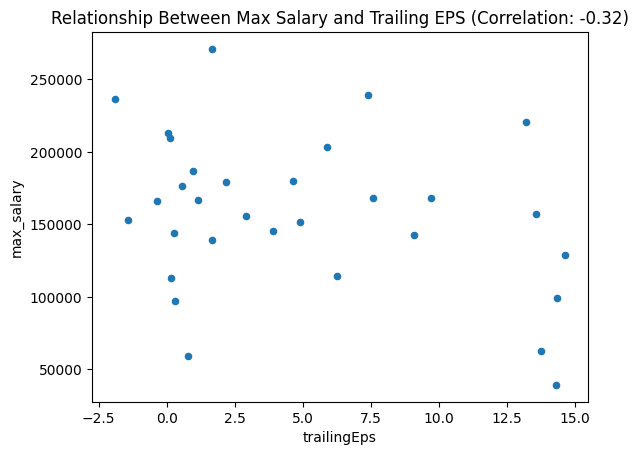

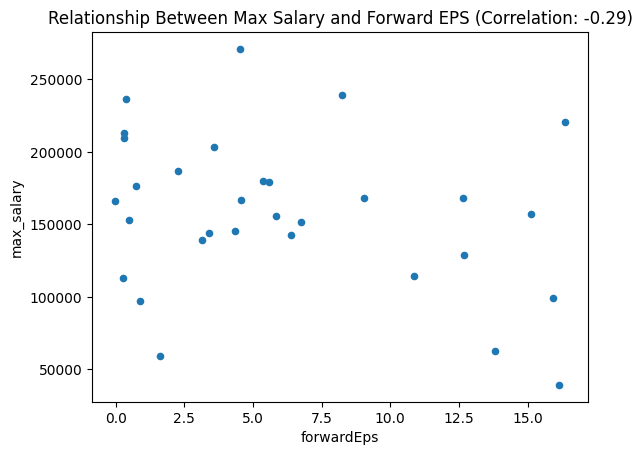

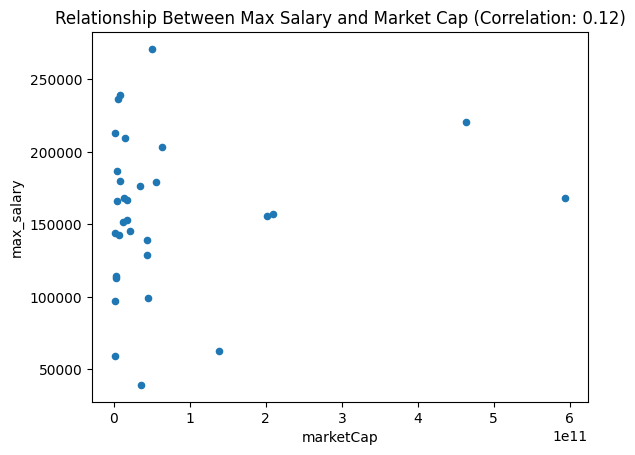

In [205]:
# Seems


# We see a fairly strong negative correlation between maximum salary and EPS (both trailing and forward looking);
cor = companies_df_2[companies_df_2['company_type']=='public']['trailingEps'].corr(companies_df_2[companies_df_2['company_type']=='public']['max_salary'])
companies_df_2[companies_df_2['company_type']=='public'].plot.scatter(x='trailingEps',y='max_salary',title=f"Relationship Between Max Salary and Trailing EPS (Correlation: {round(cor,2)})")

cor = companies_df_2[companies_df_2['company_type']=='public']['forwardEps'].corr(companies_df_2[companies_df_2['company_type']=='public']['max_salary'])
companies_df_2[companies_df_2['company_type']=='public'].plot.scatter(x='forwardEps',y='max_salary',title=f"Relationship Between Max Salary and Forward EPS (Correlation: {round(cor,2)})")

cor = companies_df_2['marketCap'].corr(companies_df_2['max_salary'])
companies_df_2[companies_df_2['company_type']=='public'].plot.scatter(x='marketCap',y='max_salary',title=f"Relationship Between Max Salary and Market Cap (Correlation: {round(cor,2)})")


In [193]:
companies_df_2['marketCap'].sort_values(ascending=True)

,marketCap
26,5.803491e+08
66,9.615336e+08
42,1.020162e+09
77,1.071400e+09
97,1.987938e+09
...,...
110,NaN
111,NaN
112,NaN
113,NaN


# Export Tidy Files

In [213]:
companies_df_2.to_csv(f'/content/drive/MyDrive/companies_df_2_{today}.csv')

In [214]:
jobs_df.to_csv(f'/content/drive/MyDrive/jobs_df_{today}.csv')